In [1]:
import dataloader
import sys
import time
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import gc

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed, Flatten

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

%load_ext autoreload
%autoreload 2

path = "../032721Comparison/Data/AMZN2021.csv"
date = datetime.datetime(2021,3,12)
count = 1200
# We will use the previous 60 days as features
history_size = 60

In [2]:
# Compute MAE
def mae(y_hat, y):
    # mean absolute error
    return np.abs(y_hat - y).mean()

def rmse(y_hat, y):
    # root mean squared error
    return np.sqrt(np.mean(np.power((y-y_hat),2)))

In [3]:
df = dataloader.load_data_up_to_date(path, date, count)

(1258, 7)
(1257, 7)
(1257, 7)
(1200, 7)


In [8]:
amzn_closing_all = df['Close'].to_numpy()
# reshape to 1200 x 1 matrix
amzn_closing_all = np.reshape(amzn_closing_all, (amzn_closing_all.shape[0], -1))
amzn_closing_all.shape

(1200, 1)

In [9]:
#converting prices to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(amzn_closing_all)
train = scaled_data[:1000,:]
test = scaled_data[1000:, :]

In [10]:
train_x, train_y = [], []
test_x, test_y = [], []
for i in range(history_size,len(train)):
    train_x.append(scaled_data[i-history_size:i,0])
    train_y.append(scaled_data[i,0])
train_x, train_y = np.array(train_x), np.array(train_y)

train_x = np.reshape(train_x, (train_x.shape[0],train_x.shape[1], 1))
print(train_x.shape)

for i in range(len(train),len(scaled_data)):
    test_x.append(scaled_data[i-history_size:i,0])
    test_y.append(scaled_data[i,0])
test_x, test_y = np.array(test_x), np.array(test_y)

test_x = np.reshape(test_x, (test_x.shape[0],test_x.shape[1], 1))
print(test_x.shape)



(940, 60, 1)
(200, 60, 1)


In [11]:
# How many features do we want to pass as hidden unit
UNITS = range(2, 60, 2)
K = 5
model = None
gc.collect()

best_unit_count = None
# Best Validation Error
best_err = sys.maxsize

for unit_count in UNITS:
    kf = KFold(n_splits=K, random_state=None, shuffle=False)
    y_err = []
    
    
    # Cross Validaiton
    for train_index, val_index in kf.split(train_x):
        X_train, X_val = train_x[train_index], train_x[val_index]
        y_train, y_val = train_y[train_index], train_y[val_index]
    
        model = Sequential()
        model.add(LSTM(units=unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(RepeatVector(X_train.shape[1]))
        model.add(LSTM(units=unit_count, return_sequences=True))
        model.add(Flatten())
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0)
        y_hat = model.predict(X_val).transpose()[0]
        del model
        gc.collect()
        
        y_err.append(rmse(y_hat, y_val))
        
    print(str(unit_count), "mean val RMSE:", np.mean(y_err))

    if np.mean(y_err) < best_err:
        best_err = np.mean(y_err)
        best_unit_count = unit_count

print(best_unit_count, best_err)

2 mean val RMSE: 0.1366192476141112
4 mean val RMSE: 0.0919757333807899
6 mean val RMSE: 0.04549700266800829
8 mean val RMSE: 0.051685552788604594
10 mean val RMSE: 0.0730618504671853
12 mean val RMSE: 0.03925638909406687
14 mean val RMSE: 0.03614293045206663
16 mean val RMSE: 0.036368641230804154
18 mean val RMSE: 0.04129663786968973
20 mean val RMSE: 0.03892700204657852
22 mean val RMSE: 0.0373167501768016
24 mean val RMSE: 0.041937422026662695
26 mean val RMSE: 0.05421710323705026
28 mean val RMSE: 0.044757091129910234
30 mean val RMSE: 0.051626279284641474
32 mean val RMSE: 0.040382430411412096
34 mean val RMSE: 0.039411250710915495
36 mean val RMSE: 0.026720352259159495
38 mean val RMSE: 0.02616723458190115
40 mean val RMSE: 0.03283979864349409
42 mean val RMSE: 0.023624522640569946
44 mean val RMSE: 0.03485463448093394
46 mean val RMSE: 0.03196685258280406
48 mean val RMSE: 0.02811013783364467
50 mean val RMSE: 0.02650138939707435
52 mean val RMSE: 0.035390443842077804
54 mean va

In [12]:
model = None
gc.collect()

model = Sequential()
model.add(LSTM(units=best_unit_count, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(units=best_unit_count, return_sequences=True))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_x, train_y, epochs=100, batch_size=32, verbose=1)
print(model.summary())
y_hat = model.predict(test_x).transpose()[0]

del model
gc.collect()

Epoch 1/100
30/30 [==============================] - 0s 5ms/step - loss: 0.0087
Epoch 2/100
30/30 [==============================] - 0s 6ms/step - loss: 4.2935e-04
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 2.6695e-04
Epoch 4/100
30/30 [==============================] - 0s 12ms/step - loss: 2.8069e-04
Epoch 5/100
30/30 [==============================] - 0s 11ms/step - loss: 2.6996e-04
Epoch 6/100
30/30 [==============================] - 0s 7ms/step - loss: 2.6210e-04
Epoch 7/100
30/30 [==============================] - 0s 12ms/step - loss: 2.4949e-04
Epoch 8/100
30/30 [==============================] - 0s 10ms/step - loss: 2.4524e-04
Epoch 9/100
30/30 [==============================] - 0s 11ms/step - loss: 2.1933e-04
Epoch 10/100
30/30 [==============================] - 0s 12ms/step - loss: 2.1520e-04
Epoch 11/100
30/30 [==============================] - 0s 7ms/step - loss: 2.1207e-04
Epoch 12/100
30/30 [==============================] - 0s 10ms/step - lo

30/30 [==============================] - 0s 12ms/step - loss: 1.4817e-04
Epoch 97/100
30/30 [==============================] - 0s 12ms/step - loss: 1.3443e-04
Epoch 98/100
30/30 [==============================] - 0s 12ms/step - loss: 1.4264e-04
Epoch 99/100
30/30 [==============================] - 0s 12ms/step - loss: 1.2889e-04
Epoch 100/100
30/30 [==============================] - 0s 12ms/step - loss: 1.3460e-04
Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_290 (LSTM)              (None, 42)                7392      
_________________________________________________________________
repeat_vector_145 (RepeatVec (None, 60, 42)            0         
_________________________________________________________________
lstm_291 (LSTM)              (None, 60, 42)            14280     
_________________________________________________________________
flatten_145 (Flatten)        (

39010

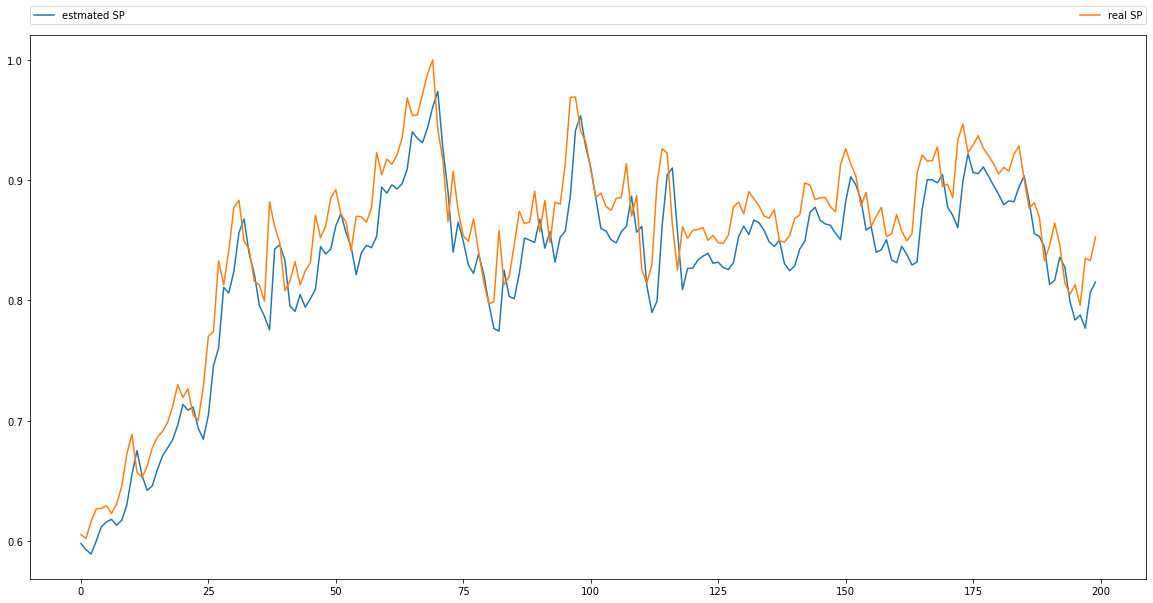

In [13]:
plt.plot(y_hat[:], label="estmated SP")
plt.plot(test_y[:], label="real SP")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.show()

In [14]:
print("MAE:  ", mae(y_hat, test_y))
print("RMSE: ", rmse(y_hat, test_y))

MAE:   0.026370012529753108
RMSE:  0.032580836280679745
